In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal as mvn


In [ ]:
np.random.seed(42)
T = 100  
state_dim = 2  
obs_dim = 1    

# Ma trận chuyển trạng thái ẩn (2 chế độ)
P = np.array([[0.95, 0.05],
              [0.05, 0.95]])

# Chế độ ban đầu
z = np.zeros(T, dtype=int)
z[0] = 0 if np.random.rand() < 0.5 else 1


F = [np.array([[1, 0], [0, 1]]),     
     np.array([[1, 1], [0, 1]])]     

Q = [0.01 * np.eye(2), 0.1 * np.eye(2)]  

H = np.array([[1, 0]]) 
R = 0.1 * np.eye(1)     

# Khởi tạo trạng thái thực và quan sát
x = np.zeros((T, state_dim))
y = np.zeros((T, obs_dim))
x[0] = [0, 1] 

for t in range(1, T):
    z[t] = np.random.choice([0, 1], p=P[z[t-1]])  
    x[t] = F[z[t]] @ x[t-1] + mvn(mean=np.zeros(state_dim), cov=Q[z[t]])
    y[t] = H @ x[t] + mvn(mean=np.zeros(obs_dim), cov=R)


In [ ]:

x_filt = np.zeros((T, 2, state_dim))
P_filt = np.zeros((T, 2, state_dim, state_dim))  
w_filt = np.zeros((T, 2))  

x_filt[0, 0] = x[0]
x_filt[0, 1] = x[0]
P_filt[0, :, :, :] = np.array([np.eye(state_dim)] * 2)
w_filt[0] = [0.5, 0.5]

def kalman_predict(x, P, F, Q):
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred

def kalman_update(x_pred, P_pred, y, H, R):
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ (y - H @ x_pred)
    P_upd = (np.eye(len(P_pred)) - K @ H) @ P_pred
    return x_upd, P_upd


for t in range(1, T):
    likelihoods = np.zeros(2)
    for j in range(2): 
        
        x_mix = np.zeros(state_dim)
        P_mix = np.zeros((state_dim, state_dim))
        w_pred = 0
        for i in range(2):  
            w_ij = w_filt[t-1, i] * P[i, j]
            x_mix += w_ij * x_filt[t-1, i]
            P_mix += w_ij * (P_filt[t-1, i] + np.outer(x_filt[t-1, i] - x_mix, x_filt[t-1, i] - x_mix))
            w_pred += w_ij
        x_mix /= w_pred
        P_mix /= w_pred

        
        x_pred, P_pred = kalman_predict(x_mix, P_mix, F[j], Q[j])
        x_upd, P_upd = kalman_update(x_pred, P_pred, y[t], H, R)

        
        S = H @ P_pred @ H.T + R
        err = y[t] - H @ x_pred
        ll = np.exp(-0.5 * err.T @ np.linalg.inv(S) @ err) / np.sqrt(np.linalg.det(2*np.pi*S))
        likelihoods[j] = ll * w_pred

        x_filt[t, j] = x_upd
        P_filt[t, j] = P_upd


    w_filt[t] = likelihoods / np.sum(likelihoods)


C:\Users\Admin\AppData\Local\Temp\ipykernel_31888\1927059165.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  plt.plot([np.sum(w_filt[t, j] * x_filt[t, j, 0] for j in range(2)) for t in range(T)], 'b--', label='Ước lượng')


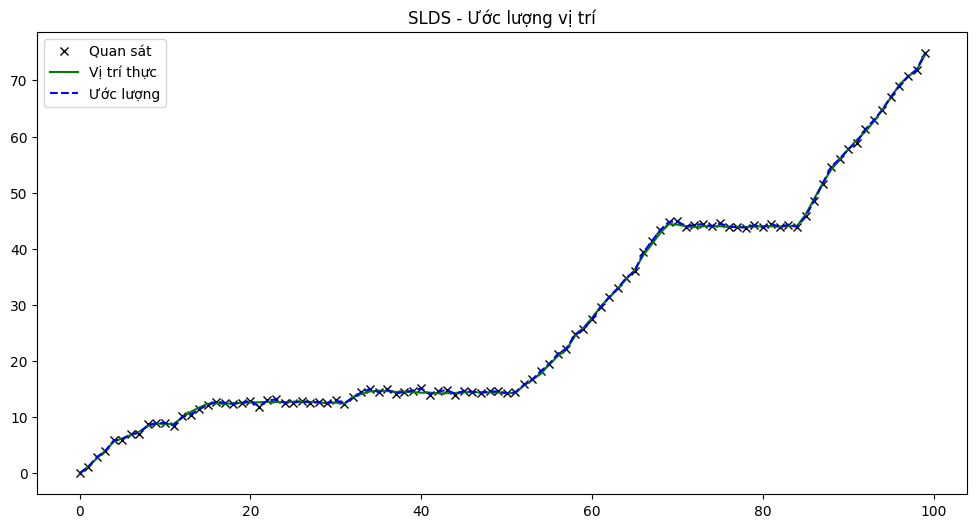

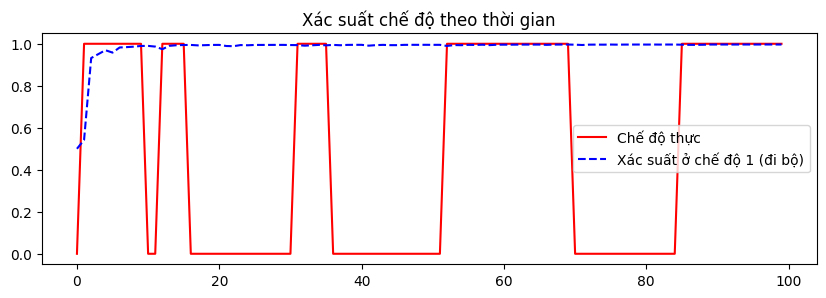

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(y, 'kx', label='Quan sát')
plt.plot(x[:, 0], 'g-', label='Vị trí thực')
plt.plot([np.sum(w_filt[t, j] * x_filt[t, j, 0] for j in range(2)) for t in range(T)], 'b--', label='Ước lượng')
plt.title('SLDS - Ước lượng vị trí')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(z, 'r-', label='Chế độ thực')
plt.plot(w_filt[:, 1], 'b--', label='Xác suất ở chế độ 1 (đi bộ)')
plt.title('Xác suất chế độ theo thời gian')
plt.legend()
plt.show()
